## Asset-Liability Management

In [1]:
import pandas as pd
import numpy as np
import edhc_risk_kit as erk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2

Asset Liability Management (ALM) can be defined as a mechanism to address the risk faced by a bank due to a mismatch between assets and liabilities either due to liquidity or changes in interest rates. Liquidity is an institution’s ability to meet its liabilities either by borrowing or converting assets. Apart from liquidity, a bank may also have a mismatch due to changes in interest rates as banks typically tend to borrow short term (fixed or floating) and lend long term (fixed or floating).

# Present Value of Liabilities and Funding Ratio

We will examine how to discount future liabilities to compute the present value of future liabilities, and measure the funding ratio. The funding ratio is the ratio of the current value of assets to the present value of the liabilities. In order to compute the present value, we need to discount the amount of the liability based on the relevant interest rate derived from the yield curve. For simplicity, we'll assume that the yield curve is flat, and so the interest rate is the same for all horizons.

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$

Assume that you have 4 liabilities, of 1, 1.5, 2, and 2.5M dollars. Assume the first of these are 3 years away and the subsequent ones are spaced out 6 months apart, i.e. at time 3, 3.5, 4 and 4.5 years from now. Let's compute the present value of the liabilities based on an interest rate of 3% per year.

In an individual investment context, you can think oif liabilities as Goals, such as saving for Life Events such as a down payment for a house, college expenses for your children, or retirement income. In each of these cases, we have a requirement of a cash flow at some point in the future ... anytime you have a future cash requirement, you can think of it as a liability.

In [2]:
# Example calculating discounted value
erk.discount_simple(10, .03)

0.7440939148967249

In [3]:
# Example calculating present value
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
erk.pv_simple(liabilities, 0.03)

6.233320315080045

We can now compute the funding ratio, based on current asset values:

In [4]:
# Example calculating the funding ration
erk.funding_ratio_simple(5, liabilities, 0.03)

0.8021407126958777

Thus, in order to be able to meet the future liabilities as specified in `liabilities` at the indicated future times, the present funding ratio should be 80.2% (6.23 million in current assets in order to pay 7 million at years 3, 3.5, 4, and 4.5).

As the widget below shows, even if your assets do not go down in value, cash can be a risky asset if you think about the funding ratio rather than the asset value. Even though cash is a "safe asset" in the sense that the asset value does not go down, cash can be a very risky asset because the value of the liabilities goes up when interest rates go down. Therefore, if you think about your savings in terms of funding ratio (i.e. how much money do you have compared to what you need) then cash is a risky asset and can result in a decline in your funding ratio.

In [5]:
def show_funding_ratio(assets, r):
    fr = erk.funding_ratio_simple(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We saw above that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

The function `inst_to_ann` converts an instantaneous (or short) rate to an annulaized rate while the function `ann_to_inst` does the opposite. The function `cir` implements the CIR model (see `edhc_risk_kit.py`).

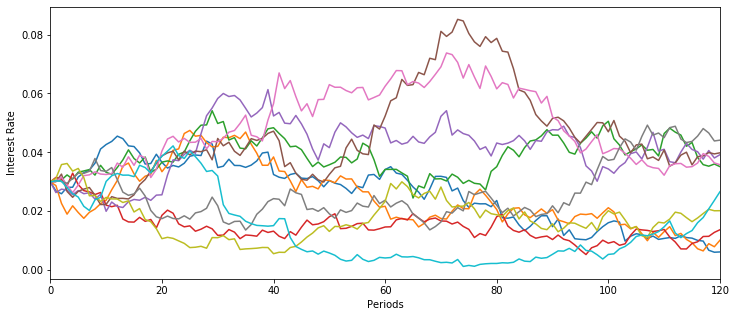

In [6]:
rates, prices = erk.cir(n_scenarios=10)
rates.plot(legend=False, figsize=(12,5))
plt.xlabel('Periods')
plt.ylabel('Interest Rate');

In [7]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    rates, prices = erk.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)
    rates.plot(legend=False, figsize=(12,5))
    
import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [8]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    rates, prices = erk.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)
    prices.plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Assume our liabilities are to pay one dollar in 10 years time. Clearly, the liability is perfectly matched by the price of a zero coupon bond that matures in 10 years. Therefore, this is perfectly matched by buying a zero coupon bond. 

In [9]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices.copy()
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = float(a_0/zc_0)
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

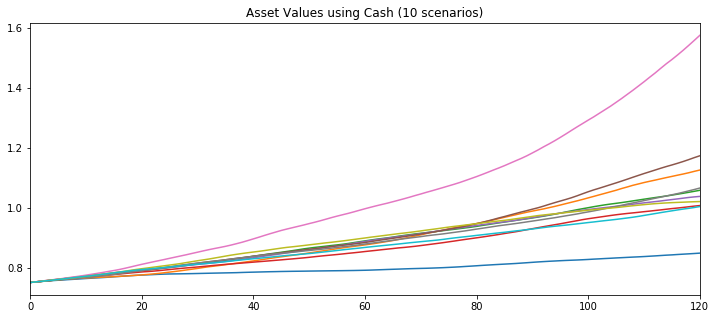

In [10]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5));

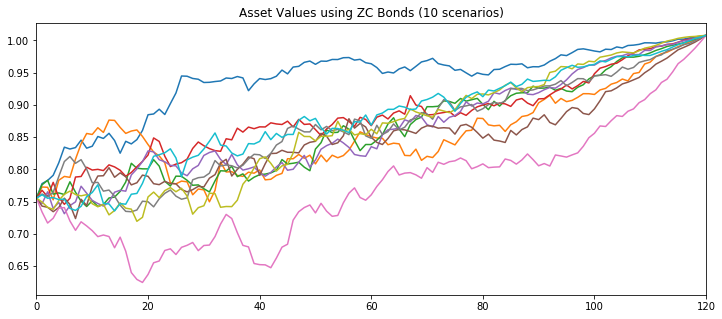

In [11]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

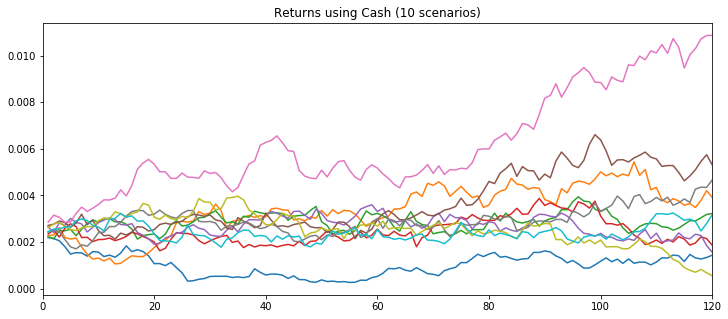

In [12]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5));

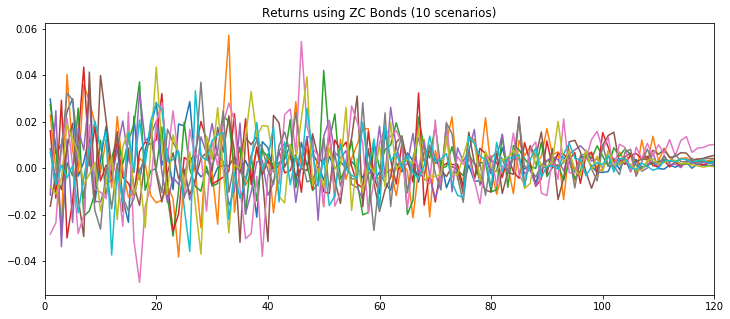

In [13]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5));

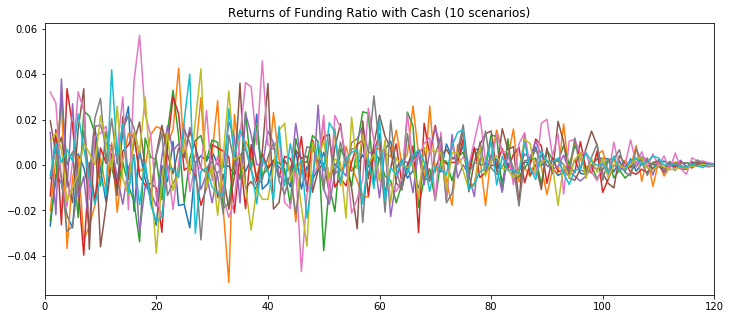

In [14]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5));

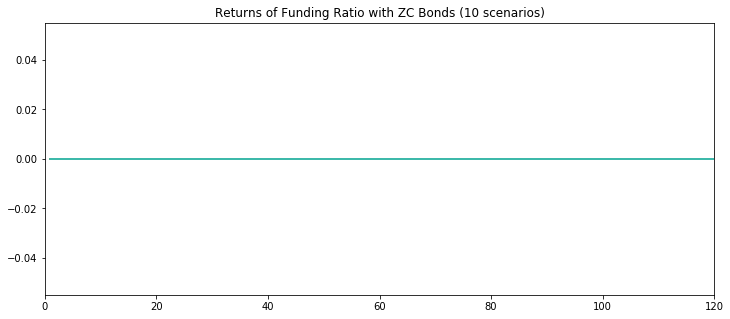

In [15]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5));

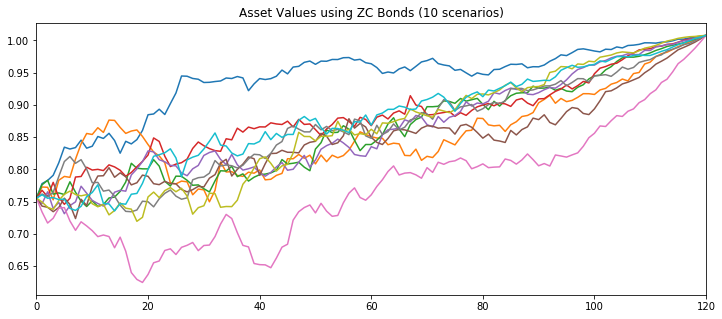

In [16]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5));

### Terminal Funding Ratios

We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations:

In [17]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

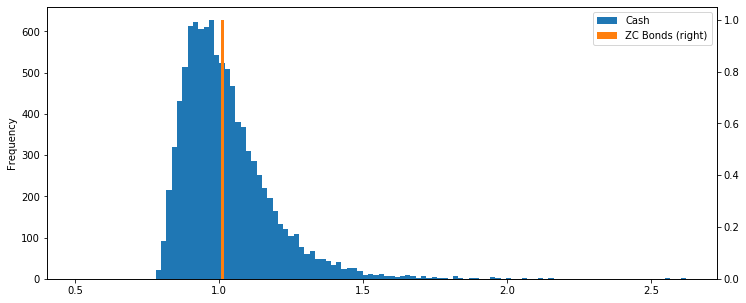

In [18]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True);

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

We shall try and address these later. We address the first by holding a portfolio of non zero coupon bonds that will behave like a zero coupon bond in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. We'll address the second issue by introducing a second building block to deliver the higher performance to try and close the gap between your current assets and the upside target.

# GHP Construction with Duration matching

As seen before, we can easily match a liability if we had a zero coupon bond that had the exact maturity as the liability, in which case, assuming we had enough funds available, we could do perfect cash flow matching. Next, we'll use a portfolio of standard, non-coupon bonds to try and achieve the same behaviour as a zero coupon bond.

In order to do this, we'll have to find a way to price a bond, but as it turns out, we've already written the code to do this. Recall that we implemented the code to compute the present value of a sequence of liability cash flows. Well, a bond is nothing more than a series of cash flows that the issuer is offering to make to you, and therefore, the price of a bond is nothing more than the present value of the future cash flows. To be more precise, we should use discount rates matching the payment horizons using the yield curve. For simplicity, we'll assume that the yield curve is flat, and the rate of interest is the same regardless of whether it is 1 year, 5 year, 10 year or 30 year horizon. We'll also assume that bonds pay a monthly coupon thereby avoiding some of the complexities of intra-coupon payment. 

In [19]:
# Example for a bond which matures in 20 years, a face value of 1000, a coupon rate of 5%
# two coupons per year and a discount rate of 4%
print(erk.bond_price(20, 1000, 0.05, 2, .04))

0    1136.777396
dtype: float64


## Bond prices change with interest rates

Consider the following chart that shows the change in value of a bond for interest rates from 2% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $1000.

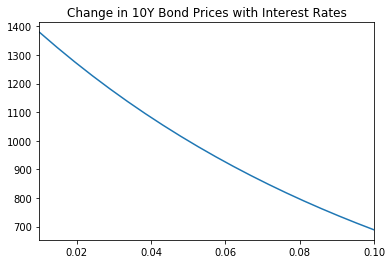

In [20]:
rates = np.linspace(.01, .10, num=20)
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", legend=False);

Assume that we have a liability of \$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

What is available are various bonds with maturities from 5 to 30 years. How do we build a portfolio that has the same sensitivity to interest rates as our liabilities do? If they both respond the same way to changes in interest rates, we can effectively obtain immunity to interest rate changes.

One way to do this is through _Duration Matching_. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio. As it happens, the duration of a bond which is computed as the weighted average time of the cash flows, weighted by the cash flows.

Thus the duration of a Zero Coupon bond is just the maturity, since there is a single cash flow at maturity.

_______________________________________

The Macaulay Duration which is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back. In this example, we'll need to wait about 5.58/2 = 2.79 years on average to get back the present value of the bond. You can also compute something called the _Modified Duration_ which gives you a more direct measure of how much the bond price will move for a small change in interest rates (i.e. the first derivative of the bond price with respect to interest rates). However, we won't need to compute that since the Macaulay Duration is itself a measure of sensitivity and all we need to do is to match that to our liability.

In [21]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), 0.06/2)

5.579707187194534

# Duration Matching

Assume we have a liability of 100K in 10 years time and another of 100K in 12 years time. Assume interest rates are 4%. What is the duration of the liabilities?

In [53]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. What are the durations of these bonds?

In [54]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
print(md_10)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)
print(md_20)

8.190898824083233
13.544718122145921


Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

The function `match_duration` in the `edhc_risk_kit` will do this for us.

In [55]:
# Example
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s # the weight for the short bond

0.48263092069478974

In [56]:
p_short = erk.bond_price(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
dm_assets=pd.concat([a_0*w_s*short_bond/float(p_short),a_0*(1-w_s)*long_bond/float(p_long)])
erk.macaulay_duration(dm_assets, 0.04)

10.960799385088393

In [57]:
cfr = erk.funding_ratio(dm_assets, liabilities, 0.04)
cfr

0.9998760012192478

In [59]:
lb_assets = a_0*long_bond/float(p_long)
sb_assets = a_0*short_bond/float(p_short)

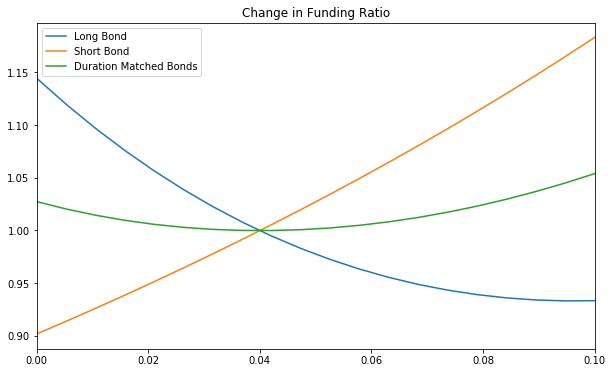

In [61]:
rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(dm_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6));

## Conclusion

We've seen that if you have the assets on hand, you can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.


# Monte Carlo Simulation of Prices of Coupon-Bearing Bond using CIR

As we have seen in the previous sessions, if we are fully funded, the best way to ensure that you will remain fully funded and be able to meet your liabilities is to build a portfolio of immunized bonds that are designed to match the future liability cash flows.

In practice, few of us, both in a Pension Fund context and even more so in a Personal Investment context, already have the assets to fund all future liabilities. Other than in cases where 100% funding ratios are mandated by law, the far more common situation is that we typically do not have the assets we need to fully fund our future liabilities.

That is where we need to allocate the wealth that we do have between the Performance Seekeng Component, and the Goal Hedging Component that we have already seen.

Therefore the next steps for us are to allocate our capital across two assets: the PSP and the GHP. The PSP, or Performance Seeking Portfolio, is where we consciously take some risk in the hope that the extra risk is well rewarded - in other words, a high Sharpe Ratio portfolio. The GHP or Goal Hedging Portfolio is the immnized bond portfolio that designed to protect us in case the worst case happens and we do not get the returns that we hope for from the PSP.

This of course raises the question of how much to allocate to the PSP and how much to the GHP. Clearly, allocating more to the PSP entails a higher expected return but a higher degree of risk. On the other hand, allocating too little to the PSP means less risk, but lower expected return. Thus, the decision of how much to allocate to the PSP vs the GHP is essentially a risk budgeting exercise.

We'll start out by developing the framework and in the next few lab sessions, examine different risk budgeting options.

First, we'll need to make a choice of the PSP. For now, we'll start with something fairly simple, which is the Geometric Brownian Motion based random stock portfolios. Much of the second MOOC in this series is focused on how to build good PSPs in practice.

However, we'll also need to pick a GHP. We can use Zero Coupon Bonds driven by random changes in interest rates using the CIR model. Since these are Zero Coupon, they are already immunized against interest rates if they are held to maturity. In practice, we've seen that even if we arent able to buy Zero Coupon bonds, we can construct bond portfolios that are designed to be insensitive to interest rates through duration matching.

In this section, we'll develop the code necessary to simulate bond prices of coupon-bearing bonds and see how their prices change as interest rates fluctuate. We'll limit ourselves to Treasury Bonds and ignore credit risk (i.e. the risk of default on the Bond).

_______________________________

Note that when interest rates rise, it is a fallacy that holding an allocation to bonds will give you the benefit of that increase. In fact, the opposite happens since the price of the bond will fall, and as a result your account sill suffer a capital loss.

Let's examine what happens to your wealth when you use a portfolio of stocks and bonds over a 5 year period.

For simplicity, we'll assume you are holding a bond that has a maturity of 5 years and for simplicity with avoiding intra-coupon caclulations, let's assume it pays a 5% coupon and the coupon is paid out each month and interest rates change from 3% to 3.2%


In [62]:
erk.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

In [70]:
erk.bond_price(5,100,.05,12,.032)

0    108.306703
dtype: float64

We'll generate interest rates using the CIR model:

In [71]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

When we start out, all rates are at 3% and so the prices are all the same:

In [72]:
erk.bond_price(5,100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [73]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.030307,0.029996,0.026692
2,0.032991,0.027870,0.025434
3,0.030861,0.026119,0.021171
4,0.027953,0.027743,0.023850


At t=0 interest rates are the same across all scenarios. However at the first step, we see that (i) the maturity decreases and (ii) interest rates change, and so the bond prices diverge:

In [74]:
erk.bond_price(5,100,.05,12, rates.iloc[1][[1,2,3]])

1    109.125987
2    109.277389
3    110.898669
dtype: float64

### Simulating Prices of a Coupon-bearing Bond

From the ability to compute bond prices from rates, we can stitch together the prices of a bond over time:

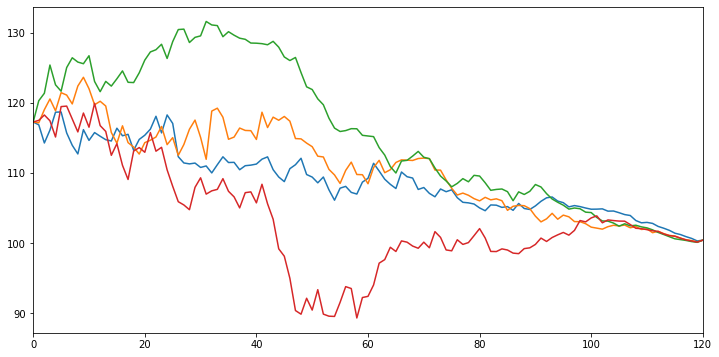

In [76]:
erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]]).plot(legend=False, figsize=(12,6));

In [77]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
prices.head()

,1,2,3,4
0,117.26,117.26,117.26,117.26
1,116.849,117.141,120.288,117.492
2,114.267,119.015,121.353,118.256
3,116.097,120.536,125.377,117.434
4,118.656,118.853,122.556,115.12


Because the interest rate at the time we bought the bond was less than the coupon rate, we bought it at a premium, taking a capital loss when we sold it at the end. We need to compute the Total Return of a bond, which is the price return PLUS the dividend with the function `bond_total_return`.

In [78]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr, 12)

1    0.030874
2    0.030251
3    0.028392
4    0.033571
dtype: float64

Which gives us the approximately 3% return we expected, because that was the prevailing rate when we bought it. We also assumed that we reinvested the coupon in the bond and that is why we did not get the exact same return in each case, since we would observe prices based on the then-prevalent interest rates.

## Putting it all together: Monte Carlo Simulation of Asset Allocation

Now that we have a way to generate prices from which to derive returns, we can experiment with allocating across the different Asset Classes.

Let's start by examining the performance of a 70-30 allocation to Stocks and Bonds. Assume Stocks return an average of 7% per year with a 15% vol and use the CIR model to generate bond prices for a 10 year and 30 year bond that pays a 5% coupon. For simplicity, assume the coupon is paid monthly to avoid having to deal with partial coupons. Assume the Bond Portfolio consists of 60% in the 10 year bond and 40% in the 30 year bond.

In [79]:
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = .6*rets_10 + .4*rets_30 # assume monthly rebalancing
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035354,0.003288,0.032074,3.174579,-0.001357,-0.000966,1.584777,0.0


Similarly, for a mix of equities (70%) and bonds (30%).

In [80]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets = .70*rets_eq + 0.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.061454,0.004337,-0.211188,3.012804,-0.002859,-0.002244,7.059044,0.0


# Naive Risk Budgeting Strategies between PSP and GHP

## The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second.

Let's run the experiment we ran before ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [81]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.0354,0.004218,0.354116,3.464066,-0.001046,-0.000532,1.246094,0.0


TBD 128.ipynb

**Questions 1-3**  

- B1 is a 15 Year Bond with a Face Value of 1000 that pays a 5% coupon semi-annually (2 times a year)  
- B2 is a 5 Year Bond with a Face value of 1000 that pays a 6% coupon quarterly (4 times a year)
- B3 is a 10 Year Zero-Coupon Bond with a Face Value of 1000

Which of the three bonds is the most expensive? Which of the three bonds is the least expensive?

In [82]:
B1 = erk.bond_price(15, 1000, 0.05, 2, 0.05)
B2 = erk.bond_price(5, 1000, 0.06, 4, 0.05)
print('Price of B1:', float(B1))
print('Price of B2:', float(B2))
print('Price of B3', 1000/(1.05)**10)

Price of B1: 1000.0000000000018
Price of B2: 1043.998290335565
Price of B3 613.9132535407591


**Questions 4-6**  
Which of the three bonds has the highest (Macaulay) Duration?

In [106]:
D1 = erk.macaulay_duration(erk.bond_cash_flows(15, 1000, 0.05, 2), 0.05/2) / 2
D2 = erk.macaulay_duration(erk.bond_cash_flows(5, 1000, 0.06, 4), 0.05/4) / 4
#D3 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.00), 0.05)
print('Duration of B1:', D1)
print('Duration of B2:', D2)
print('Duration of B3:', 9.52)

Duration of B1: 10.72677495379012
Duration of B2: 4.373363222636413
Duration of B3: 9.52


**Question 7**  
Assume a sequence of 3 liabilities of 100,000, 200,000 and 300,000 that are 3, 5 and 10 years away, respectively. What is the Duration of the liabilities?

In [91]:
liabilities7 = pd.Series(data = [100000, 200000, 300000], index=[3, 5, 10])
erk.macaulay_duration(liabilities7, .05)

6.750917852744651

**Question 8**  
Assuming the same set of liabilities as the previous question (i.e. a sequence of 3 liabilities of 100,000, 200,000 and $300,000 that are 3, 5 and 10 years away, respectively) build a Duration Matched Portfolio of B1 and B2 to match these liabilities. What is the weight of B2 in the portfolio? (Hint: the code we developed in class erk.match_durations() assumes that all the bonds have the same number of coupons per year. This is not the case here, so you will either need to enhance the code or compute the weight directly e.g. by entering the steps in a Jupyter Notebook Cell or at the Python Command Line)

**Question 9**  
Assume you can use any of the bonds B1, B2 and B3 to build a duration matched bond portfolio matched to the liabilities. Which combination of 2 bonds can you NOT use to build a duration matched bond portfolio?

**Question 10**  
Assuming the same liabilities as the previous questions (i.e. a sequence of 3 liabilities of 100,000, 200,000 and 300,000 that are 3, 5 and 10 years away, respectively), build a Duration Matched Portfolio of B2 and B3 to match the liabilities.  
What is the weight of B2 in this portfolio?

In [108]:
# Example
short_bond = erk.bond_cash_flows(5, 1000, .05, 4)
long_bond = erk.bond_cash_flows(10, 1000, .05, 1)
w_s = erk.match_durations(liabilities7, short_bond, long_bond, 0.05)
w_s # the weight for the short bond

-0.15692430327980286